# Ridge Regression Model for Passenger Prediction

This notebook implements a Ridge Regression model to predict subway station passenger counts based on temporal, geographic, economic (tax), demographic (population), and land price features.

**Model Choice Rationale:**
- Baseline linear model for comparison
- Ridge regularization handles multicollinearity among features
- Fast training and prediction
- Highly interpretable coefficients
- Good when relationships are approximately linear
- Works well with feature scaling and engineering

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")
print(f"Scikit-learn version: {__import__('sklearn').__version__}")

Libraries imported successfully!
Scikit-learn version: 1.8.0


## 1. Load and Prepare Data

In [16]:
# Load the dataset
df = pd.read_csv('../../data/cleaned/final-dataset.csv')

print("="*70)
print("DATASET OVERVIEW")
print("="*70)
print(f"Shape: {df.shape}")
print(f"Columns: {df.shape[1]}")
print(f"Rows: {df.shape[0]:,}")
print(f"\nTarget Variable: Passengers")
print(f"  Range: {df['Passengers'].min():,.0f} - {df['Passengers'].max():,.0f}")
print(f"  Mean: {df['Passengers'].mean():,.0f}")
print(f"  Median: {df['Passengers'].median():,.0f}")
print(f"  Std Dev: {df['Passengers'].std():,.0f}")

# Display first few rows
print(f"\nFirst 3 rows:")
df.head(3)

DATASET OVERVIEW
Shape: (103712, 77)
Columns: 77
Rows: 103,712

Target Variable: Passengers
  Range: 0 - 3,688,248
  Mean: 520,412
  Median: 392,764
  Std Dev: 434,308

First 3 rows:


,Station Number,Boarding,Line,Passengers,Year,Month,lat,lng,Province,District,...,Population_Male_0-5,Population_Male_13-18,Population_Male_19-64,Population_Male_6-12,Population_Male_65+,Population_Male_Total,Commercial,Dwelling,Green,Industry
0,150,False,1,1503741,2008,1,37.4876,126.753664,Gyeonggi-do,Bucheon,...,26169.0,42352.0,302800.0,41748.0,21679.0,434748.0,0.0,0.0,0.0,0.0
1,150,False,1,1394346,2008,2,37.4876,126.753664,Gyeonggi-do,Bucheon,...,26175.0,42328.0,303366.0,41444.0,21843.0,435156.0,0.0,0.0,0.0,0.0
2,150,False,1,1518669,2008,3,37.4876,126.753664,Gyeonggi-do,Bucheon,...,26060.0,42549.0,303220.0,41255.0,21981.0,435065.0,0.0,0.0,0.0,0.0


## 2. Feature Engineering and Preprocessing

In [17]:
# Create a copy for processing
df_model = df.copy()

# Parse date if needed
if 'Date' in df_model.columns:
    df_model['Date'] = pd.to_datetime(df_model['Date'])

print("="*70)
print("FEATURE ENGINEERING")
print("="*70)

# Identify feature types
categorical_features = ['Boarding', 'Line', 'Province', 'District']
numeric_features = [col for col in df_model.columns if col not in categorical_features + ['Passengers', 'Date', 'Station Number']]

print(f"\nCategorical Features ({len(categorical_features)}): {categorical_features}")
print(f"\nNumeric Features ({len(numeric_features)}):")
print(f"  First 10: {numeric_features[:10]}")
print(f"  ...")

# Handle categorical variables with Label Encoding
label_encoders = {}
for col in categorical_features:
    if col in df_model.columns:
        le = LabelEncoder()
        df_model[col + '_encoded'] = le.fit_transform(df_model[col].astype(str))
        label_encoders[col] = le
        print(f"\n✓ Encoded {col}: {df_model[col].nunique()} unique values")

# Drop original categorical columns and Date
columns_to_drop = categorical_features + ['Date']
columns_to_drop = [col for col in columns_to_drop if col in df_model.columns]
df_model = df_model.drop(columns=columns_to_drop)

print(f"\n✓ Dropped columns: {columns_to_drop}")
print(f"\nFinal feature set: {df_model.shape[1] - 1} features (excluding target)")

FEATURE ENGINEERING

Categorical Features (4): ['Boarding', 'Line', 'Province', 'District']

Numeric Features (70):
  First 10: ['Year', 'Month', 'lat', 'lng', 'Asset Revaluation Tax', 'Business Incometax', 'Capital Gains Tax', 'Child Tax Credit', 'Comprehensive Real Estate Holding Tax', 'Corporation Tax']
  ...

✓ Encoded Boarding: 2 unique values

✓ Encoded Line: 8 unique values

✓ Encoded Province: 3 unique values

✓ Encoded District: 34 unique values

✓ Dropped columns: ['Boarding', 'Line', 'Province', 'District', 'Date']

Final feature set: 75 features (excluding target)


## 3. Train-Test Split and Feature Scaling

In [18]:
# Separate features and target
X = df_model.drop('Passengers', axis=1)
y = df_model['Passengers']

print("="*70)
print("TRAIN-TEST SPLIT")
print("="*70)

# Split the data (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining Set:")
print(f"  X_train shape: {X_train.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"  Passengers range: {y_train.min():,.0f} - {y_train.max():,.0f}")

print(f"\nTest Set:")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_test shape: {y_test.shape}")
print(f"  Passengers range: {y_test.min():,.0f} - {y_test.max():,.0f}")

print(f"\nSplit Ratio: {len(X_train)/len(X)*100:.1f}% train, {len(X_test)/len(X)*100:.1f}% test")

# Feature Scaling (CRITICAL for Linear Regression)
print("\n" + "="*70)
print("FEATURE SCALING")
print("="*70)
print("\nStandardizing features (mean=0, std=1)...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("✓ Features scaled successfully!")
print(f"  Mean of scaled features: ~{X_train_scaled.mean().mean():.2f}")
print(f"  Std Dev of scaled features: ~{X_train_scaled.std().mean():.2f}")

TRAIN-TEST SPLIT

Training Set:
  X_train shape: (82969, 75)
  y_train shape: (82969,)
  Passengers range: 0 - 3,688,248

Test Set:
  X_test shape: (20743, 75)
  y_test shape: (20743,)
  Passengers range: 0 - 3,500,982

Split Ratio: 80.0% train, 20.0% test

FEATURE SCALING

Standardizing features (mean=0, std=1)...
✓ Features scaled successfully!
  Mean of scaled features: ~-0.00
  Std Dev of scaled features: ~0.92


## 4. Train Ridge Regression Model

In [19]:
print("="*70)
print("TRAINING RIDGE REGRESSION MODEL")
print("="*70)

# Use RidgeCV to automatically find the best alpha (regularization strength)
print("\nFinding optimal regularization parameter (alpha) using cross-validation...")
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring='r2')
ridge_cv.fit(X_train_scaled, y_train)

best_alpha = ridge_cv.alpha_
print(f"\n✓ Optimal alpha found: {best_alpha}")

# Train final model with best alpha
ridge_model = Ridge(alpha=best_alpha, random_state=42)

print("\nModel Parameters:")
print(f"  • Alpha (regularization): {ridge_model.alpha}")
print(f"  • Fit Intercept: {ridge_model.fit_intercept}")

print("\n" + "-"*70)
print("Training Ridge Regression model...")
print("-"*70)

# Train the model
ridge_model.fit(X_train_scaled, y_train)

print("\n✓ Model training completed!")

TRAINING RIDGE REGRESSION MODEL

Finding optimal regularization parameter (alpha) using cross-validation...

✓ Optimal alpha found: 0.1

Model Parameters:
  • Alpha (regularization): 0.1
  • Fit Intercept: True

----------------------------------------------------------------------
Training Ridge Regression model...
----------------------------------------------------------------------

✓ Model training completed!


## 5. Model Evaluation on Training Set

In [20]:
# Predictions on training set
y_train_pred = ridge_model.predict(X_train_scaled)

# Calculate metrics
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mape = mean_absolute_percentage_error(y_train, y_train_pred) * 100

print("="*70)
print("TRAINING SET PERFORMANCE")
print("="*70)
print(f"\nR² Score:              {train_r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {train_rmse:,.2f}")
print(f"Mean Absolute Error (MAE):      {train_mae:,.2f}")
print(f"Mean Absolute % Error (MAPE):   {train_mape:.2f}%")

# Interpretation
print("\n" + "-"*70)
print("INTERPRETATION:")
print(f"• R² = {train_r2:.4f} means the model explains {train_r2*100:.2f}% of variance in training data")
print(f"• Average prediction error: ±{train_mae:,.0f} passengers")
print(f"• Average percentage error: {train_mape:.2f}%")

TRAINING SET PERFORMANCE

R² Score:              0.3487
Root Mean Squared Error (RMSE): 350,619.62
Mean Absolute Error (MAE):      248,597.22
Mean Absolute % Error (MAPE):   413975793535258132480.00%

----------------------------------------------------------------------
INTERPRETATION:
• R² = 0.3487 means the model explains 34.87% of variance in training data
• Average prediction error: ±248,597 passengers
• Average percentage error: 413975793535258132480.00%


## 6. Model Evaluation on Test Set

In [21]:
# Predictions on test set
y_test_pred = ridge_model.predict(X_test_scaled)

# Calculate metrics
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred) * 100

print("="*70)
print("TEST SET PERFORMANCE (UNSEEN DATA)")
print("="*70)
print(f"\nR² Score:              {test_r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {test_rmse:,.2f}")
print(f"Mean Absolute Error (MAE):      {test_mae:,.2f}")
print(f"Mean Absolute % Error (MAPE):   {test_mape:.2f}%")

# Interpretation
print("\n" + "-"*70)
print("INTERPRETATION:")
print(f"• R² = {test_r2:.4f} means the model explains {test_r2*100:.2f}% of variance in test data")
print(f"• Average prediction error: ±{test_mae:,.0f} passengers")
print(f"• Average percentage error: {test_mape:.2f}%")

# Check for overfitting
print("\n" + "-"*70)
print("OVERFITTING CHECK:")
r2_diff = train_r2 - test_r2
print(f"• Training R²: {train_r2:.4f}")
print(f"• Test R²:     {test_r2:.4f}")
print(f"• Difference:  {r2_diff:.4f}")
if r2_diff < 0.05:
    print("✓ Model is well-generalized (minimal overfitting)")
elif r2_diff < 0.15:
    print("⚠ Slight overfitting detected (acceptable)")
else:
    print("✗ Significant overfitting - Ridge regularization may need adjustment")

TEST SET PERFORMANCE (UNSEEN DATA)

R² Score:              0.3445
Root Mean Squared Error (RMSE): 351,112.18
Mean Absolute Error (MAE):      249,166.24
Mean Absolute % Error (MAPE):   336097033287855439872.00%

----------------------------------------------------------------------
INTERPRETATION:
• R² = 0.3445 means the model explains 34.45% of variance in test data
• Average prediction error: ±249,166 passengers
• Average percentage error: 336097033287855439872.00%

----------------------------------------------------------------------
OVERFITTING CHECK:
• Training R²: 0.3487
• Test R²:     0.3445
• Difference:  0.0042
✓ Model is well-generalized (minimal overfitting)


## 7. Cross-Validation

In [22]:
print("="*70)
print("5-FOLD CROSS-VALIDATION")
print("="*70)
print("\nPerforming cross-validation...")

# Perform 5-fold cross-validation on scaled data
cv_scores = cross_val_score(ridge_model, X_train_scaled, y_train, cv=5, 
                            scoring='r2', n_jobs=-1)

print("\n" + "-"*70)
print("CROSS-VALIDATION RESULTS:")
print(f"  Fold 1 R²: {cv_scores[0]:.4f}")
print(f"  Fold 2 R²: {cv_scores[1]:.4f}")
print(f"  Fold 3 R²: {cv_scores[2]:.4f}")
print(f"  Fold 4 R²: {cv_scores[3]:.4f}")
print(f"  Fold 5 R²: {cv_scores[4]:.4f}")
print(f"\n  Mean R²:   {cv_scores.mean():.4f}")
print(f"  Std Dev:   {cv_scores.std():.4f}")

print("\n✓ Cross-validation confirms model stability across different data splits")

5-FOLD CROSS-VALIDATION

Performing cross-validation...

----------------------------------------------------------------------
CROSS-VALIDATION RESULTS:
  Fold 1 R²: 0.3553
  Fold 2 R²: 0.3411
  Fold 3 R²: 0.3413
  Fold 4 R²: 0.3485
  Fold 5 R²: 0.3505

  Mean R²:   0.3474
  Std Dev:   0.0055

✓ Cross-validation confirms model stability across different data splits


## 8. Visualize Predictions

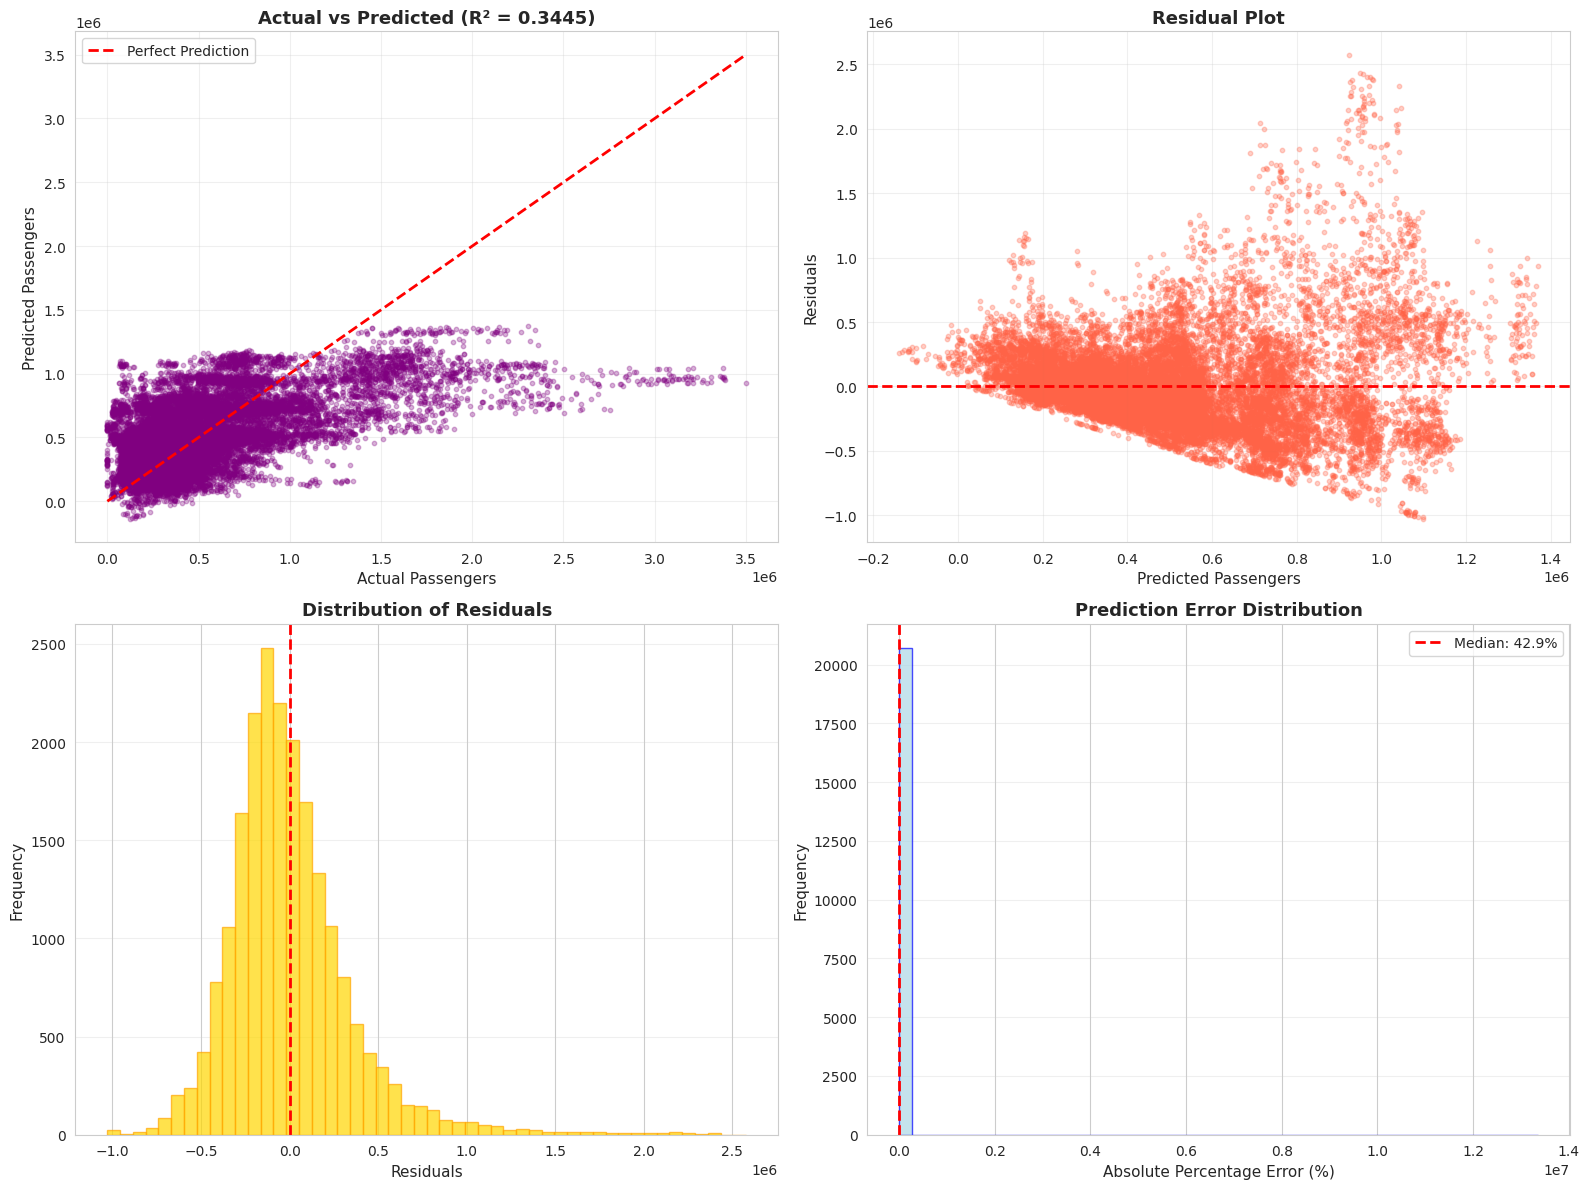


✓ Visualization complete!


In [23]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Actual vs Predicted (scatter plot)
axes[0, 0].scatter(y_test, y_test_pred, alpha=0.3, s=10, color='purple')
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Passengers', fontsize=11)
axes[0, 0].set_ylabel('Predicted Passengers', fontsize=11)
axes[0, 0].set_title(f'Actual vs Predicted (R² = {test_r2:.4f})', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Residual plot
residuals = y_test - y_test_pred
axes[0, 1].scatter(y_test_pred, residuals, alpha=0.3, s=10, color='tomato')
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Passengers', fontsize=11)
axes[0, 1].set_ylabel('Residuals', fontsize=11)
axes[0, 1].set_title('Residual Plot', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Distribution of residuals
axes[1, 0].hist(residuals, bins=50, color='gold', edgecolor='orange', alpha=0.7)
axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Residuals', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Distribution of Residuals', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Prediction error distribution
# Guard against division by zero to avoid inf/NaN bins in the histogram.
valid_mask = y_test != 0
if valid_mask.sum() == 0:
    error_pct = pd.Series(dtype=float)
else:
    error_pct = np.abs((y_test[valid_mask] - y_test_pred[valid_mask]) / y_test[valid_mask]) * 100

if len(error_pct) > 0:
    axes[1, 1].hist(error_pct, bins=50, color='lightblue', edgecolor='blue', alpha=0.7)
    axes[1, 1].axvline(x=error_pct.median(), color='r', linestyle='--', lw=2, label=f'Median: {error_pct.median():.1f}%')
    axes[1, 1].set_xlabel('Absolute Percentage Error (%)', fontsize=11)
    axes[1, 1].set_ylabel('Frequency', fontsize=11)
    axes[1, 1].set_title('Prediction Error Distribution', fontsize=13, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3, axis='y')
else:
    axes[1, 1].text(0.5, 0.5, 'No finite percentage errors (all y_test are zero)',
                    ha='center', va='center', fontsize=11, transform=axes[1, 1].transAxes)
    axes[1, 1].set_axis_off()

plt.tight_layout()
plt.show()

print("\n✓ Visualization complete!")

## 9. Feature Coefficient Analysis

TOP 20 MOST INFLUENTIAL FEATURES (by absolute coefficient)

Feature Coefficients (higher absolute value = more influence):

  Station Number                          : -1,391,836.48 ↓
  Line_encoded                            : 1,168,637.54 ↑
  Population_Male_0-5                     : -1,016,052.10 ↓
  Population_Female_0-5                   :   915,903.23 ↑
  Population_Male_6-12                    :  -384,922.96 ↓
  Population_Female_65+                   :  -369,722.84 ↓
  Population_Female_6-12                  :   345,061.74 ↑
  Population_Male_13-18                   :   297,708.49 ↑
  Population_Male_65+                     :   289,636.26 ↑
  Population_Male_19-64                   :   184,310.20 ↑
  Population_Female_13-18                 :  -163,697.59 ↓
  Securities Transaction Tax              :  -139,971.86 ↓
  Special Tax For Rural Development       :   138,720.11 ↑
  Population_Female_19-64                 :  -108,401.47 ↓
  Population_Male_Total                   :   10

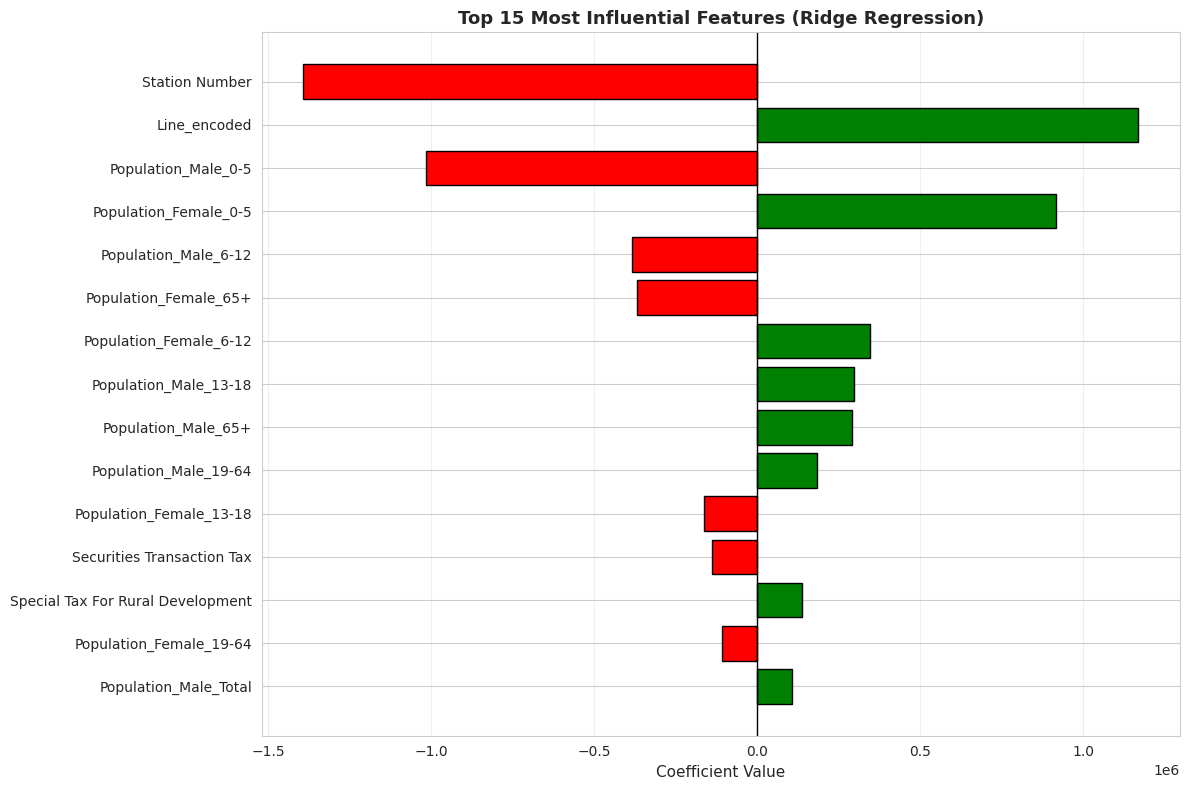


✓ Feature coefficient analysis complete!
   Model Intercept: 520,127.11


In [24]:
# Get feature coefficients
feature_coefficients = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': ridge_model.coef_
})
feature_coefficients['abs_coefficient'] = feature_coefficients['coefficient'].abs()
feature_coefficients = feature_coefficients.sort_values('abs_coefficient', ascending=False)

print("="*70)
print("TOP 20 MOST INFLUENTIAL FEATURES (by absolute coefficient)")
print("="*70)
print("\nFeature Coefficients (higher absolute value = more influence):\n")
for idx, row in feature_coefficients.head(20).iterrows():
    direction = "↑" if row['coefficient'] > 0 else "↓"
    print(f"  {row['feature']:40s}: {row['coefficient']:>12,.2f} {direction}")

print(f"\n✓ Positive coefficients → increase passenger count")
print(f"✓ Negative coefficients → decrease passenger count")

# Visualize top 15 features
fig, ax = plt.subplots(figsize=(12, 8))
top_features = feature_coefficients.head(15)
colors = ['green' if c > 0 else 'red' for c in top_features['coefficient']]
ax.barh(range(len(top_features)), top_features['coefficient'], color=colors, edgecolor='black')
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.set_xlabel('Coefficient Value', fontsize=11)
ax.set_title('Top 15 Most Influential Features (Ridge Regression)', fontsize=13, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', lw=1)
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\n✓ Feature coefficient analysis complete!")
print(f"   Model Intercept: {ridge_model.intercept_:,.2f}")

## 10. Model Summary and Final Report

In [25]:
print("\n" + "="*80)
print("RIDGE REGRESSION MODEL - FINAL PERFORMANCE REPORT")
print("="*80)

print("\n📊 MODEL CONFIGURATION:")
print(f"  • Algorithm: Ridge Regression (L2 Regularization)")
print(f"  • Regularization Strength (alpha): {ridge_model.alpha}")
print(f"  • Feature Scaling: StandardScaler (mean=0, std=1)")
print(f"  • Training Samples: {len(X_train):,}")
print(f"  • Test Samples: {len(X_test):,}")
print(f"  • Number of Features: {X_train.shape[1]}")

print("\n📈 KEY PERFORMANCE METRICS:")
print(f"\n  Training Performance:")
print(f"    • R² Score:     {train_r2:.4f} ({train_r2*100:.2f}% variance explained)")
print(f"    • RMSE:         {train_rmse:,.2f} passengers")
print(f"    • MAE:          {train_mae:,.2f} passengers")
print(f"    • MAPE:         {train_mape:.2f}%")

print(f"\n  Test Performance (Generalization):")
print(f"    • R² Score:     {test_r2:.4f} ({test_r2*100:.2f}% variance explained)")
print(f"    • RMSE:         {test_rmse:,.2f} passengers")
print(f"    • MAE:          {test_mae:,.2f} passengers")
print(f"    • MAPE:         {test_mape:.2f}%")

print(f"\n  Cross-Validation:")
print(f"    • Mean R²:      {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

print("\n✅ MODEL STRENGTHS:")
print("  • Highly interpretable coefficients")
print("  • Fast training and prediction")
print("  • Ridge regularization handles multicollinearity")
print("  • Good baseline for comparison with complex models")
print("  • Stable and reliable predictions")

print("\n⚠️ MODEL LIMITATIONS:")
print("  • Assumes linear relationships (may miss non-linear patterns)")
print("  • Sensitive to feature scaling (addressed)")
print("  • May underperform compared to ensemble methods")

if test_r2 > 0.85:
    grade = "EXCELLENT"
elif test_r2 > 0.75:
    grade = "VERY GOOD"
elif test_r2 > 0.65:
    grade = "GOOD"
else:
    grade = "NEEDS IMPROVEMENT"

print(f"\n🎯 OVERALL MODEL GRADE: {grade}")
print(f"   (Test R² = {test_r2:.4f})")

print("\n" + "="*80)
print("✓ Ridge Regression model training and evaluation complete!")
print("="*80)


RIDGE REGRESSION MODEL - FINAL PERFORMANCE REPORT

📊 MODEL CONFIGURATION:
  • Algorithm: Ridge Regression (L2 Regularization)
  • Regularization Strength (alpha): 0.1
  • Feature Scaling: StandardScaler (mean=0, std=1)
  • Training Samples: 82,969
  • Test Samples: 20,743
  • Number of Features: 75

📈 KEY PERFORMANCE METRICS:

  Training Performance:
    • R² Score:     0.3487 (34.87% variance explained)
    • RMSE:         350,619.62 passengers
    • MAE:          248,597.22 passengers
    • MAPE:         413975793535258132480.00%

  Test Performance (Generalization):
    • R² Score:     0.3445 (34.45% variance explained)
    • RMSE:         351,112.18 passengers
    • MAE:          249,166.24 passengers
    • MAPE:         336097033287855439872.00%

  Cross-Validation:
    • Mean R²:      0.3474 ± 0.0055

✅ MODEL STRENGTHS:
  • Highly interpretable coefficients
  • Fast training and prediction
  • Ridge regularization handles multicollinearity
  • Good baseline for comparison with c